In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from io import BytesIO

import pandas as pd
import matplotlib.pyplot as plt

from data_collector import Omie

In [3]:
filename = "curva_pbc"
date = "20211001"

date = pd.to_datetime(date).strftime("%Y%m%d")
filename_date = f"{filename}_{date}.1"

cols = [
    "hour", "date", "country", "unit", "offer_type", "energy", "price", "status"
]

In [ ]:
content = Omie._download_content(family_file=filename, filename=filename_date)

In [ ]:
filebytes = BytesIO(content)

In [ ]:
df = pd.read_csv(filebytes, delimiter=";", index_col=False, skiprows=3, names=cols, encoding="latin-1")
df.drop(["unit"], axis=1, inplace=True)
df.dropna(inplace=True)

df["price"] = df["price"].str.replace(".", "").str.replace(",", ".").astype(float)
df["energy"] = df["energy"].str.replace(".", "").str.replace(",", ".").astype(float)

In [ ]:
df_1 = df[df["hour"] == 1]

In [ ]:
df_offer = df_1[(df_1["offer_type"] == "V") & (df_1["status"] == "O")].sort_values("price")
df_offer["agg_energy"] = df_offer["energy"].cumsum() 

In [ ]:
df_demand = df_1[(df_1["offer_type"] == "C") & (df_1["status"] == "O")].sort_values("price", ascending=False)
df_demand["agg_energy"] = df_demand["energy"].cumsum()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
df_offer.plot(x="agg_energy", y="price", ax=ax, label="ask")
df_demand.plot(x="agg_energy", y="price", ax=ax, label="bid")
ax.set_xlim(11000, 24000)
ax.set_ylim(-10, 300)

In [ ]:
df_units = pd.read_csv("curva_pbc_uof_20211001.1", delimiter=";", index_col=False, skiprows=3, encoding="latin-1",
                      names=cols)
df_units.dropna(inplace=True)

df_units["price"] = df_units["price"].str.replace(".", "").str.replace(",", ".").astype(float)
df_units["energy"] = df_units["energy"].str.replace(".", "").str.replace(",", ".").astype(float)

In [ ]:
df_units_offer = df_units[
    (df_units["hour"] == 1) & (df_units["offer_type"] == "V") & (df_units["status"] == "O")
].sort_values("price")

In [ ]:
df_offer

In [ ]:
df_units_offer.head(50)

In [9]:
filename = "curva_pbc_uof"
year = 2016
month = 1
year_month = f"{year}{month:02d}"

date_file_pattern = f"{filename}_{year_month}"
filename_zip = date_file_pattern + ".zip"

In [10]:
content = Omie._download_content(family_file=filename, filename=filename_zip)

In [11]:
unzip_file = Omie._decompress_zip(zip_content=content)

In [12]:
d = pd.to_datetime(f'{year}-{month}')
dates = pd.date_range(start=d.strftime("%Y-%m-%d"), periods=d.daysinmonth, freq="D")  

df_units_list = []
for d in dates:
    file_pattern = Omie.date_file_pattern.format(filename=filename, date_str=d.strftime("%Y%m%d"))
    file_list = [s for s in unzip_file.namelist() if file_pattern in s]
    
    if len(file_list) > 1:
        print(f"There are multiple files for {file_pattern}: {len(file_list)}")
    
    file = file_list[-1]

    filebytes = unzip_file.open(name=file, mode="r")
    
    df = pd.read_csv(filepath_or_buffer=filebytes, 
                     delimiter=";", index_col=False, skiprows=3, encoding="latin-1",
                     names=cols)
    df = Omie._parse_floats(df=df, col_name="price")
    df = Omie._parse_floats(df=df, col_name="energy")
    df.dropna(inplace=True)
    
    df_units_list.append(df)

/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name] = df[col_name].str.replace(".", "").str.replace(",", ".").astype(float)
/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name] = df[col_name].str.replace(".", "").str.replace(",", ".").astype(float)
/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name

/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name] = df[col_name].str.replace(".", "").str.replace(",", ".").astype(float)
/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name] = df[col_name].str.replace(".", "").str.replace(",", ".").astype(float)
/home/antonio/Desktop/projects/electricity/data_collector/omie.py:36: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[col_name

In [54]:
df_curves_month = pd.concat(df_units_list, ignore_index=True)

In [59]:
cc_unit_offers = df_curves_month[(df_curves_month["unit"] == "SBO3") & 
                (df_curves_month["status"] == "O")].sort_values(["date", "hour"])

In [60]:
cc_unit_offers["total_enegy"] = cc_unit_offers.groupby(['date', "hour"])['energy'].transform('sum')
cc_unit_offers["weighted_price"] = (cc_unit_offers["price"] * cc_unit_offers["energy"]) /\
                                    cc_unit_offers["total_enegy"]

In [61]:
cc_unit_offers

,hour,date,country,unit,offer_type,energy,price,status,total_enegy,weighted_price
988051,1.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
990653,2.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
993143,3.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
995176,4.0,16/01/2016,MI,SBO3,V,12.0,1.13,O,397.4,0.034122
995674,4.0,16/01/2016,MI,SBO3,V,385.4,180.30,O,397.4,174.855611
...,...,...,...,...,...,...,...,...,...,...
2089754,24.0,31/01/2016,MI,SBO3,V,23.0,47.60,O,397.4,2.754907
2089773,24.0,31/01/2016,MI,SBO3,V,23.0,48.82,O,397.4,2.825516
2089795,24.0,31/01/2016,MI,SBO3,V,23.0,50.04,O,397.4,2.896125
2089829,24.0,31/01/2016,MI,SBO3,V,23.0,51.27,O,397.4,2.967313


<AxesSubplot:xlabel='date,hour'>

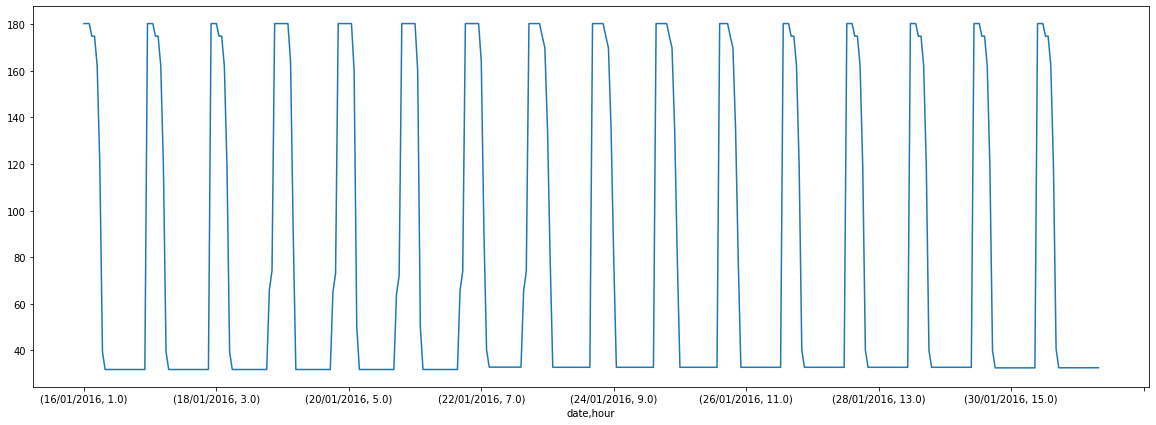

In [57]:
cc_unit_offers.groupby(["date", "hour"])["weighted_price"].sum().plot(figsize=(20, 7))

In [62]:
cc_unit_offers.groupby(["date", "hour"])["weighted_price"].sum().head(50)

date        hour
16/01/2016  1.0     180.300000
            2.0     180.300000
            3.0     180.300000
            4.0     174.889733
            5.0     174.889733
            6.0     162.265778
            7.0     119.434499
            8.0      39.363941
            9.0      31.812833
            10.0     31.812833
            11.0     31.812833
            12.0     31.812833
            13.0     31.812833
            14.0     31.812833
            15.0     31.812833
            16.0     31.812833
            17.0     31.812833
            18.0     31.812833
            19.0     31.812833
            20.0     31.812833
            21.0     31.812833
            22.0     31.812833
            23.0     31.812833
            24.0     31.812833
17/01/2016  1.0     180.300000
            2.0     180.300000
            3.0     180.300000
            4.0     174.889733
            5.0     174.889733
            6.0     162.265778
            7.0     119.434499
            8.0      3

In [63]:
cc_unit_offers.head(50)

,hour,date,country,unit,offer_type,energy,price,status,total_enegy,weighted_price
988051,1.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
990653,2.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
993143,3.0,16/01/2016,MI,SBO3,V,397.4,180.30,O,397.4,180.300000
995176,4.0,16/01/2016,MI,SBO3,V,12.0,1.13,O,397.4,0.034122
995674,4.0,16/01/2016,MI,SBO3,V,385.4,180.30,O,397.4,174.855611
997683,5.0,16/01/2016,MI,SBO3,V,12.0,1.13,O,397.4,0.034122
998177,5.0,16/01/2016,MI,SBO3,V,385.4,180.30,O,397.4,174.855611
1000178,6.0,16/01/2016,MI,SBO3,V,40.0,1.13,O,397.4,0.113739
1000681,6.0,16/01/2016,MI,SBO3,V,357.4,180.30,O,397.4,162.152038
1002680,7.0,16/01/2016,MI,SBO3,V,135.0,1.13,O,397.4,0.383870
